# Who Will Pay Extra For Guac?
## Exploring where to put new chipotle locations
Chipotle: Mexican Grill has had a tough time recouping from the virus outbreaks in 2015 but with there stock now fully rebounded the ceo, [Brian Niccol, has said the he wants to double the amount of locations](https://www.bloomberg.com/news/articles/2019-03-14/chipotle-becomes-another-boring-chain-and-that-s-a-good-thing). The chain currently operates 2,473 loactions in 47 states. Those states being Alaska, Hawaii, and South Dakota. Safegraph was kind enough to give me access to some Chipotle specific visitor data. Using the [SafeGraph Open Census Data](https://docs.safegraph.com/docs/open-census-data) along with the [Safegraph Consumer and Visitor Insights for Neighborhoods Data](https://www.safegraph.com/neighborhood-demographics-consumer-insights) will enable my analysis of popular brands for over 220,000 neighborhoods in America along with demographic information from the US census. Using the Chipotle specific visitor data that I mentioned earlier as well as some information that I scraped from Chipotle's website will provide the neccessary information to feed a deeper analysis of the burrito chain in question. My goal is to identify factors that make certain Chipotle locations more succesful than others and find new locations that would capitilize on these insights.

In [1]:
import pandas as pd
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)
from scipy import stats
import glob
import re

## Starting with the Population Patterns
To start off I want to look at the patterns data for any trends that we can see from all census block groups.
The patterns data columns are formatted in the follwing order

- census_block_group: The unique 12-digit FIPS code for the Census Block Group
- date_range_start: Start time for measurement period as a timestamp in UTC seconds
- date_range_end: End time for measurement period as a timestamp in UTC seconds.
- raw_visit_count: Number of visits seen by our panel to this CGB during the date range
- visitor_home_count: This column lists all the origin home CBGs for devices that visited a destination in the CBG listed in the column census_block_group (the destination CBG). The number mapped to each home CBG indicates the number of visitors observed from this home CBG that visited census_block_group during this time period. Home CBGs with less than 50 visitors to census_block_group are not included.
- visitor_work_cbgs: This column lists all the work-location CBGs for devices that visited a destination in the CBG listed in the column census_block_group (the destination CBG). The number mapped to each work CBG indicates the number of visitors observed with this work CBG that visited census_block_group during this time period. Work CBGs with less than 50 visitors to census_block_group are not include
- distance_from_home: Median distance from home traveled to CBG by visitors (of visitors whose home we have identified) in meters
- related_same_day_brand: Brands that the visitors to this CBG visited on the same day as their visit to the CBG where customer overlap differs by at least 5% from the SafeGraph national average to these brands. Order by strength of difference and limited to top ten brands.
- related_same_month_brand: Brands that the visitors to this CBG visited on the same month as their visit to the CBG where customer overlap differs by at least 5% from the SafeGraph national average. Order by strength of difference and limited to top ten brands.
- top_brands: A list of the the top brands visited in the CBG during the time period. Limited to top 10 brands.
- popularity_by_hour: A mapping of hour of the day to the number of visits in each hour over the course of the date range in local time.
- popularity_by_day: A mapping of day of week to the number of visits on each day (local time) in the course of the date range.

In [2]:
dtyp = {'census_block_group': 'object', 'date_range_start': 'int', 'date_range_end':'int', 'raw_visit_count': 'float', 'raw_visitor_count': 'float', 'visitor_home_cbgs':'object', 'visitor_work_cbgs':'object', 'distance_from_home':'float', 'related_same_day_brand':'object', 'related_same_month_brand':'object', 'top_brands':'object', 'top_brands':'object', 'popularity_by_hour':'object', 'popularity_by_day':'object'} 
cbg_pat = pd.read_csv('cbg_patterns.csv', dtype=dtyp)
print(cbg_pat.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220735 entries, 0 to 220734
Data columns (total 13 columns):
census_block_group          220734 non-null object
date_range_start            220735 non-null int32
date_range_end              220735 non-null int32
raw_visit_count             220629 non-null float64
raw_visitor_count           220629 non-null float64
visitor_home_cbgs           220735 non-null object
visitor_work_cbgs           220735 non-null object
distance_from_home          220518 non-null float64
related_same_day_brand      220735 non-null object
related_same_month_brand    220735 non-null object
top_brands                  220735 non-null object
popularity_by_hour          220735 non-null object
popularity_by_day           220735 non-null object
dtypes: float64(3), int32(2), object(8)
memory usage: 20.2+ MB
None


As we can see above, some of our columns have missing values. In order to properly analyze this dataset I will remove the all of the null values.

In [3]:
cbg_pat = cbg_pat.dropna()

In [4]:
cbg_pat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220518 entries, 0 to 220628
Data columns (total 13 columns):
census_block_group          220518 non-null object
date_range_start            220518 non-null int32
date_range_end              220518 non-null int32
raw_visit_count             220518 non-null float64
raw_visitor_count           220518 non-null float64
visitor_home_cbgs           220518 non-null object
visitor_work_cbgs           220518 non-null object
distance_from_home          220518 non-null float64
related_same_day_brand      220518 non-null object
related_same_month_brand    220518 non-null object
top_brands                  220518 non-null object
popularity_by_hour          220518 non-null object
popularity_by_day           220518 non-null object
dtypes: float64(3), int32(2), object(8)
memory usage: 21.9+ MB


In [5]:
top_brands_dict = {}
for k, v in cbg_pat['top_brands'].apply(eval).items():
    for i in v:
        if i in top_brands_dict.keys():
            top_brands_dict[i] += 1
        else:
            top_brands_dict[i] = 1

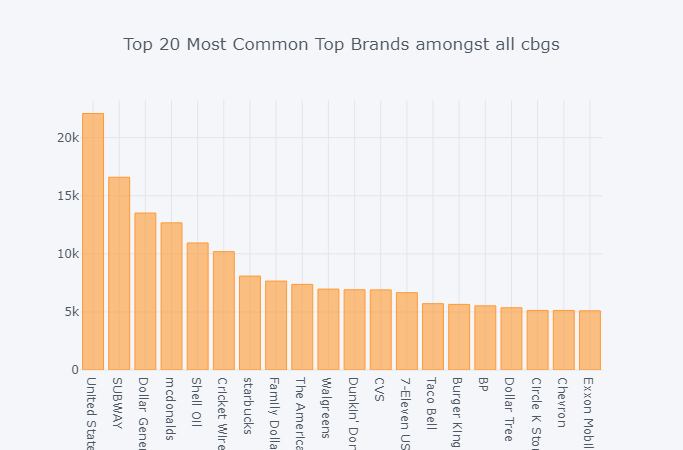

In [6]:
pd.Series(top_brands_dict).sort_values(ascending=False).iloc[:20].iplot(kind='bar', title='Top 20 Most Common Top Brands amongst all cbgs')

In [7]:
dtype = {'census_block_group': 'object', 'amount_land': 'float', 'amount_water': 'float', 'latitude': 'float', 'longitude': 'float'}
geo_d = pd.read_csv('safegraph_open_census_data/metadata/cbg_geographic_data.csv', dtype=dtype)
geo_d = geo_d.set_index('census_block_group')

In [8]:
data = cbg_pat.join(geo_d, on='census_block_group')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220518 entries, 0 to 220628
Data columns (total 17 columns):
census_block_group          220518 non-null object
date_range_start            220518 non-null int32
date_range_end              220518 non-null int32
raw_visit_count             220518 non-null float64
raw_visitor_count           220518 non-null float64
visitor_home_cbgs           220518 non-null object
visitor_work_cbgs           220518 non-null object
distance_from_home          220518 non-null float64
related_same_day_brand      220518 non-null object
related_same_month_brand    220518 non-null object
top_brands                  220518 non-null object
popularity_by_hour          220518 non-null object
popularity_by_day           220518 non-null object
amount_land                 220174 non-null float64
amount_water                220174 non-null float64
latitude                    220174 non-null float64
longitude                   220174 non-null float64
dtypes: float64(7

In [9]:
data.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220174 entries, 0 to 220628
Data columns (total 17 columns):
census_block_group          220174 non-null object
date_range_start            220174 non-null int32
date_range_end              220174 non-null int32
raw_visit_count             220174 non-null float64
raw_visitor_count           220174 non-null float64
visitor_home_cbgs           220174 non-null object
visitor_work_cbgs           220174 non-null object
distance_from_home          220174 non-null float64
related_same_day_brand      220174 non-null object
related_same_month_brand    220174 non-null object
top_brands                  220174 non-null object
popularity_by_hour          220174 non-null object
popularity_by_day           220174 non-null object
amount_land                 220174 non-null float64
amount_water                220174 non-null float64
latitude                    220174 non-null float64
longitude                   220174 non-null float64
dtypes: float64(7

## Looking at the geography of the Census Block Groups
SafeGraph put together a simple way to look at the American Census data in the most granular form by way of the 'Census Block Group'. Each block group represents a small area where commerce is conducted. This dataset shows information for over 220,000 unique locations within America. The best way to illustrate the scope of this is with a map.

In [10]:
d = go.Data([go.Scattermapbox(
            lat = data['latitude'],
            lon = data['longitude'],
            text= ["Top Brands: "  + str(n) for n in data['top_brands']],
            mode='markers',
            marker= dict(color='rgb(0, 128, 0)', size=3),
            hoverinfo='all'
            ) ])

layout = go.Layout(
        title = "All CBG locations in the US with their Top Brands",
        font= dict(family='Courier New', size=18, color='rgb(0,0,0)'),
        autosize=False,
        hovermode='closest',
        showlegend=False,
        width=1000,
        height=800,
        mapbox=dict(
            accesstoken='pk.eyJ1IjoiZGluZWxsb2oiLCJhIjoiY2swYnRpcXZ2MHkzZTNjbDZpNzExdHlwMyJ9.c5oGTN97ls11hKAKcU7BmA',
            bearing=0,
            center= dict(
                lat=38,
                lon=-94
                ),
            pitch=0,
            zoom=4,
            style='outdoors'
        ),
        )
py.plot({'data':d, 'layout':layout}, filename='all_cbg_locations_usa_map.html')

C:\Users\Jean\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




'all_cbg_locations_usa_map.html'

In [11]:
from IPython.display import IFrame

IFrame(src='all_cbg_locations_usa_map.html', width = 1000, height = 600)

# Chipotle Patterns
Safegraph offers its Neighborhood Patterns data for free. This dataset shows insights of the entire census block group. They also sell data on specific places of interest similar to the Google Places API. They graciously offered me some store credit to  their data portal to obtain specific data on Chipotle Locations in the US. This data includes everything from the neighborhood patterns dataset but is specific to the place-of-interest in this case being Chipotle Locations. This premium data also adds information about device type, showing the number of android and ios users that were among its visitors. 

In [12]:
dtype = {'safegraph_place_id': 'object', 'location_name': 'object', 'street_address': 'object', 'city': 'object', 'state':'object', 'zip_code': 'object', 'brands': 'object', 'date_range_start': 'int', 'date_range_end':'int', 'raw_visit_counts':'int', 'raw_visitor_counts': 'int', 'visits_by_day':'object', 'visitor_home_cbgs': 'object', 'visitor_work_cbgs': 'object', 'visitor_country_of_origin':'object', 'distance_from_home': 'int', 'median_dwell': 'float', 'bucketed_dwell_times':'object', 'related_same_day_brand': 'object', 'related_same_month_brand': 'object', 'popularity_by_hour': 'object', 'popularity_by_day': 'object', 'device_type':'object'} 
sg_chip06 = pd.read_csv('ChipotleMexicanGrill-PATTERNS-2019_06-2019-08-30.csv', dtype=dtype)
sg_chip07 = pd.read_csv('ChipotleMexicanGrill-PATTERNS-2019_07-2019-08-30.csv', dtype=dtype)


In [13]:
print(sg_chip06.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 23 columns):
safegraph_place_id           2319 non-null object
location_name                2319 non-null object
street_address               2319 non-null object
city                         2319 non-null object
state                        2319 non-null object
zip_code                     2319 non-null object
brands                       2319 non-null object
date_range_start             2319 non-null int32
date_range_end               2319 non-null int32
raw_visit_counts             2319 non-null int32
raw_visitor_counts           2319 non-null int32
visits_by_day                2319 non-null object
visitor_home_cbgs            2319 non-null object
visitor_work_cbgs            2319 non-null object
visitor_country_of_origin    2319 non-null object
distance_from_home           2319 non-null int32
median_dwell                 2319 non-null float64
bucketed_dwell_times         2319 non-null obje

In [14]:
sg_chip07.head()

,safegraph_place_id,location_name,street_address,city,state,zip_code,brands,date_range_start,date_range_end,raw_visit_counts,...,visitor_work_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type
0,sg:c05c7d06721b475eb3d518fcfe434f64,Chipotle Mexican Grill,3575 berlin turnpike unit b,newington,ct,06111,Chipotle Mexican Grill,1561939200,1564617600,334,...,"{""090034942013"":8,""090034001003"":5}","{""US"":267}",7350,10.0,"{""<5"":13,""5-20"":241,""21-60"":70,""61-240"":9,"">24...","{""The Home Depot"":16,""Bank of America"":11,""Jac...","{""Dunkin' Donuts"":57,""Stop & Shop"":51,""Starbuc...","[0,0,0,0,0,1,2,16,22,22,18,31,40,47,37,41,35,2...","{""Monday"":42,""Tuesday"":55,""Wednesday"":63,""Thur...","{""android"":98,""ios"":172}"
1,sg:e02f2cb1618c4ef5ae5975a274040eb8,Chipotle Mexican Grill,785 queen st unit 1,southington,ct,06489,Chipotle Mexican Grill,1561939200,1564617600,956,...,"{""090034054023"":9,""090034306012"":6,""0900340540...","{""US"":759}",8577,21.0,"{""<5"":26,""5-20"":447,""21-60"":376,""61-240"":63,"">...","{""Dunkin' Donuts"":12,""BJ's Wholesale Club"":9,""...","{""Dunkin' Donuts"":56,""Stop & Shop"":41,""McDonal...","[5,3,3,3,4,3,7,29,43,74,83,127,192,163,133,127...","{""Monday"":174,""Tuesday"":176,""Wednesday"":157,""T...","{""android"":291,""ios"":481}"
2,sg:81131f49005e48e39aac66968d30cfd9,Chipotle Mexican Grill,3610 28th street south east,kentwood,mi,49512,Chipotle Mexican Grill,1561939200,1564617600,301,...,"{""260810126081"":6,""260810126064"":5,""2608101480...","{""US"":229}",14058,16.0,"{""<5"":10,""5-20"":161,""21-60"":84,""61-240"":36,"">2...","{""Jet's Pizza"":40,""T.J. Maxx"":19,""Johnny's Mar...","{""Meijer"":55,""Starbucks"":38,""McDonald's"":38,""S...","[0,0,0,0,1,0,0,3,7,8,10,37,63,59,30,37,38,42,5...","{""Monday"":57,""Tuesday"":50,""Wednesday"":52,""Thur...","{""android"":86,""ios"":144}"
3,sg:7a60b1f4ce4b471dabfcfbe5f3915b9d,Chipotle Mexican Grill,7106 midlothian turnpike,north chesterfield,va,23225,Chipotle Mexican Grill,1561939200,1564617600,50,...,{},"{""US"":48}",8504,6.0,"{""<5"":3,""5-20"":41,""21-60"":5,""61-240"":1,"">240"":0}","{""Gold's Gym"":100,""Party City"":50,""JCPenney"":25}","{""Wawa"":63,""McDonald's"":60,""Walmart"":56,""Chick...","[0,0,0,0,0,0,0,5,3,4,5,14,4,5,6,1,1,7,3,0,2,0,...","{""Monday"":11,""Tuesday"":5,""Wednesday"":10,""Thurs...","{""android"":18,""ios"":30}"
4,sg:f5e95090748d4f7b853c59e58bace1fe,Chipotle Mexican Grill,3349 monroe avenue,rochester,ny,14618,Chipotle Mexican Grill,1561939200,1564617600,276,...,{},"{""US"":244}",10545,20.0,"{""<5"":13,""5-20"":132,""21-60"":101,""61-240"":19,"">...","{""Wegmans Food Markets"":36,""Red Roof Inn"":17,""...","{""Wegmans Food Markets"":70,""Dunkin' Donuts"":36...","[0,0,0,0,0,0,0,0,2,6,15,40,59,61,49,37,33,35,4...","{""Monday"":41,""Tuesday"":55,""Wednesday"":48,""Thur...","{""android"":73,""ios"":173}"


## Looking at device preferences
With the device information available to us I want to look at if customers choice of Mobile platform has any influence on things other factors such as distance_from_home, dwell_time, or visitor_counts.

In [15]:
sg_chip06['android'] = sg_chip06['device_type'].apply(lambda x: eval(x).get('android'))
sg_chip07['android'] = sg_chip07['device_type'].apply(lambda x: eval(x).get('android'))
sg_chip06['ios'] = sg_chip06['device_type'].apply(lambda x: eval(x).get('ios'))
sg_chip07['ios'] = sg_chip07['device_type'].apply(lambda x: eval(x).get('ios'))

In [16]:
sg_chip07.head()

,safegraph_place_id,location_name,street_address,city,state,zip_code,brands,date_range_start,date_range_end,raw_visit_counts,...,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type,android,ios
0,sg:c05c7d06721b475eb3d518fcfe434f64,Chipotle Mexican Grill,3575 berlin turnpike unit b,newington,ct,06111,Chipotle Mexican Grill,1561939200,1564617600,334,...,7350,10.0,"{""<5"":13,""5-20"":241,""21-60"":70,""61-240"":9,"">24...","{""The Home Depot"":16,""Bank of America"":11,""Jac...","{""Dunkin' Donuts"":57,""Stop & Shop"":51,""Starbuc...","[0,0,0,0,0,1,2,16,22,22,18,31,40,47,37,41,35,2...","{""Monday"":42,""Tuesday"":55,""Wednesday"":63,""Thur...","{""android"":98,""ios"":172}",98,172
1,sg:e02f2cb1618c4ef5ae5975a274040eb8,Chipotle Mexican Grill,785 queen st unit 1,southington,ct,06489,Chipotle Mexican Grill,1561939200,1564617600,956,...,8577,21.0,"{""<5"":26,""5-20"":447,""21-60"":376,""61-240"":63,"">...","{""Dunkin' Donuts"":12,""BJ's Wholesale Club"":9,""...","{""Dunkin' Donuts"":56,""Stop & Shop"":41,""McDonal...","[5,3,3,3,4,3,7,29,43,74,83,127,192,163,133,127...","{""Monday"":174,""Tuesday"":176,""Wednesday"":157,""T...","{""android"":291,""ios"":481}",291,481
2,sg:81131f49005e48e39aac66968d30cfd9,Chipotle Mexican Grill,3610 28th street south east,kentwood,mi,49512,Chipotle Mexican Grill,1561939200,1564617600,301,...,14058,16.0,"{""<5"":10,""5-20"":161,""21-60"":84,""61-240"":36,"">2...","{""Jet's Pizza"":40,""T.J. Maxx"":19,""Johnny's Mar...","{""Meijer"":55,""Starbucks"":38,""McDonald's"":38,""S...","[0,0,0,0,1,0,0,3,7,8,10,37,63,59,30,37,38,42,5...","{""Monday"":57,""Tuesday"":50,""Wednesday"":52,""Thur...","{""android"":86,""ios"":144}",86,144
3,sg:7a60b1f4ce4b471dabfcfbe5f3915b9d,Chipotle Mexican Grill,7106 midlothian turnpike,north chesterfield,va,23225,Chipotle Mexican Grill,1561939200,1564617600,50,...,8504,6.0,"{""<5"":3,""5-20"":41,""21-60"":5,""61-240"":1,"">240"":0}","{""Gold's Gym"":100,""Party City"":50,""JCPenney"":25}","{""Wawa"":63,""McDonald's"":60,""Walmart"":56,""Chick...","[0,0,0,0,0,0,0,5,3,4,5,14,4,5,6,1,1,7,3,0,2,0,...","{""Monday"":11,""Tuesday"":5,""Wednesday"":10,""Thurs...","{""android"":18,""ios"":30}",18,30
4,sg:f5e95090748d4f7b853c59e58bace1fe,Chipotle Mexican Grill,3349 monroe avenue,rochester,ny,14618,Chipotle Mexican Grill,1561939200,1564617600,276,...,10545,20.0,"{""<5"":13,""5-20"":132,""21-60"":101,""61-240"":19,"">...","{""Wegmans Food Markets"":36,""Red Roof Inn"":17,""...","{""Wegmans Food Markets"":70,""Dunkin' Donuts"":36...","[0,0,0,0,0,0,0,0,2,6,15,40,59,61,49,37,33,35,4...","{""Monday"":41,""Tuesday"":55,""Wednesday"":48,""Thur...","{""android"":73,""ios"":173}",73,173


In [17]:
print(sg_chip06['android'].describe())
sg_chip07['android'].describe()

count    2319.000000
mean      144.685209
std       105.326966
min         0.000000
25%        84.000000
50%       130.000000
75%       190.000000
max      2130.000000
Name: android, dtype: float64


count    2345.000000
mean      140.694243
std       103.430208
min         0.000000
25%        86.000000
50%       126.000000
75%       180.000000
max      2713.000000
Name: android, dtype: float64

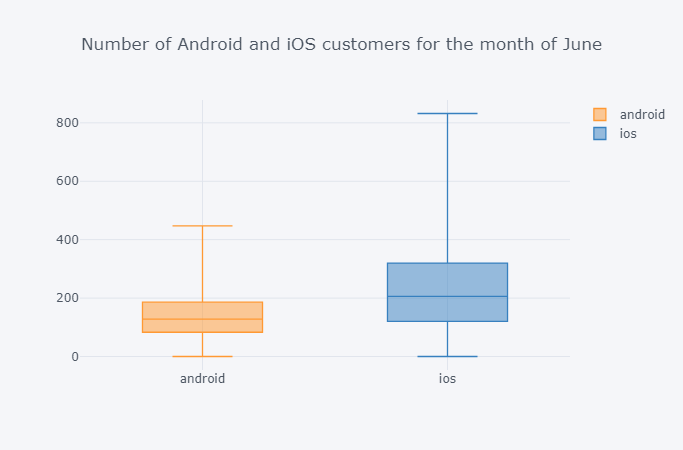

In [18]:
device = sg_chip06[['android', 'ios']]
device = device[(np.abs(stats.zscore(device)) < 3).all(axis=1)] #used to reduce outliers and keep all values within 3 std
device.iplot(kind='box', title='Number of Android and iOS customers for the month of June')

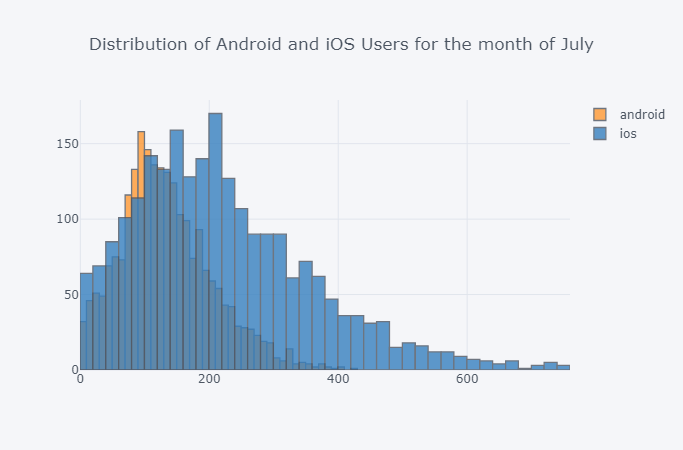

In [19]:
device = sg_chip07[['android', 'ios']]
device = device[(np.abs(stats.zscore(device)) < 3).all(axis=1)] #used to reduce outliers and keep all values within 3 std
device.iplot(kind='hist', barmode='overlay', histnorm='', title= 'Distribution of Android and iOS Users for the month of July')

In [20]:
print('Chipotle Customers Android Market Share: ' + str(round(sg_chip06['android'].sum()/(sg_chip06['android'].sum() + sg_chip06['ios'].sum()), 4) * 100) +'%')

Chipotle Customers Android Market Share: 37.26%


In [21]:
print('Chipotle Customers iOS Market Share: ' + str(round(sg_chip06['ios'].sum()/(sg_chip06['android'].sum() + sg_chip06['ios'].sum()), 3) * 100) +'%')

Chipotle Customers iOS Market Share: 62.7%


From these visualizations, it is clear that more Chipotle customers use iOS instead of Android. This is different from the national statistics, acording to this page on [Statista on market share of smartphone platforms in the US](https://www.statista.com/statistics/266572/market-share-held-by-smartphone-platforms-in-the-united-states/). In June of 2019, the market was split roughly in half with Google at a 51.1% and Apple at 48.1%. This could imply that Chipotle customers have more money as Apple products are usually more expensive. To explore this hypothesis more, we can explore other factors such as time of day, day of the week, the top related brands of the chipotle locations.

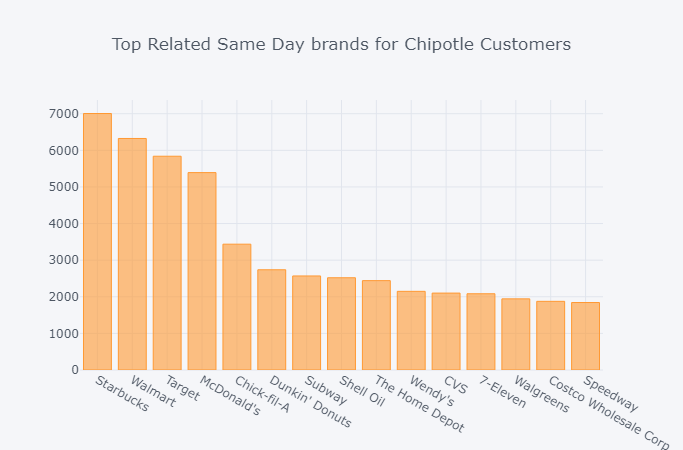

In [22]:
day_b_dict = {}
day_b = sg_chip06['related_same_day_brand'].apply(eval)
for k, v in enumerate(day_b):
    for x, y in v.items():
        if x not in day_b_dict:
            day_b_dict[x] = y
        else:
            day_b_dict[x] += y
            
pd.Series(day_b_dict).sort_values(ascending=False).iloc[:15].iplot(kind='bar', title='Top Related Same Day brands for Chipotle Customers')

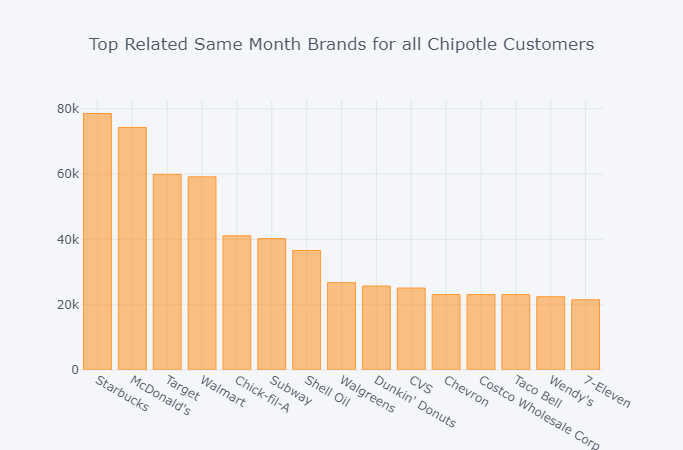

In [23]:
month_b_dict = {}
day_b = sg_chip06['related_same_month_brand'].apply(eval)
for k, v in enumerate(day_b):
    for x, y in v.items():
        if x not in month_b_dict:
            month_b_dict[x] = y
        else:
            month_b_dict[x] += y
            
pd.Series(month_b_dict).sort_values(ascending=False).iloc[:15].iplot(kind='bar', title='Top Related Same Month Brands for all Chipotle Customers')

Starbucks is the most common related brand to chipotle customers which could be considered expensive. Mcdonald's and Walmart are also some of the most common related brands and these are decidely not catered for high-end customers. Let's see what times and days are the most popular for Chipotle customers.

In [25]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in weekdays:
    sg_chip06[day] = sg_chip06['popularity_by_day'].apply(lambda x: eval(x).get(day))
    sg_chip07[day] = sg_chip07['popularity_by_day'].apply(lambda x: eval(x).get(day))

In [26]:
avg_weekdays = (sg_chip06[weekdays] + sg_chip07[weekdays])/2

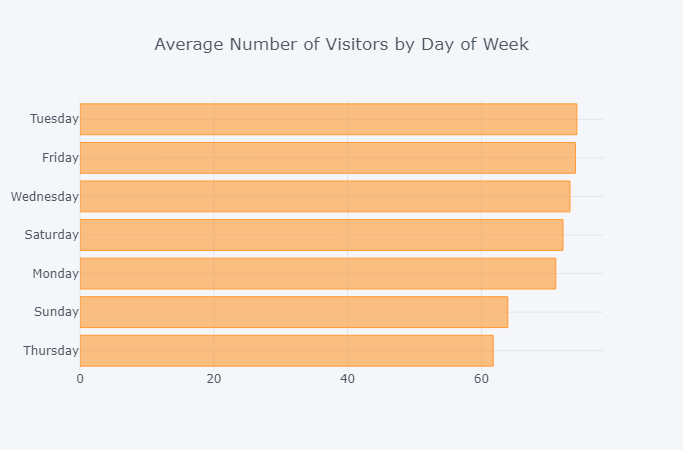

In [27]:
avg_weekdays.mean().sort_values().iplot(kind='barh', title='Average Number of Visitors by Day of Week')

In [28]:
for i in range(1, 25):
    if i//12 < 1:
        sg_chip06[str(i) + 'am'] = sg_chip06['popularity_by_hour'].apply(lambda x: eval(x)[i-1])
        sg_chip07[str(i) + 'am'] = sg_chip07['popularity_by_hour'].apply(lambda x: eval(x)[i-1])
    elif i/12 == 1:
        sg_chip06[str(i) + 'pm'] = sg_chip06['popularity_by_hour'].apply(lambda x: x[i-1])
        sg_chip07[str(i) + 'pm'] = sg_chip07['popularity_by_hour'].apply(lambda x: x[i-1])
    else:
        sg_chip06[str(i-12) + 'pm'] = sg_chip06['popularity_by_hour'].apply(lambda x: eval(x)[i-1])
        sg_chip07[str(i-12) + 'pm'] = sg_chip07['popularity_by_hour'].apply(lambda x: eval(x)[i-1])

In [29]:
times = [str(t) + 'am' for t in list(range(1,12))]
times.extend(['12pm', '1pm','2pm','3pm','4pm','5pm','6pm','7pm', '8pm', '9pm', '10pm', '11pm'])

In [30]:
avg_times = (sg_chip06[times] + sg_chip07[times])/ 2

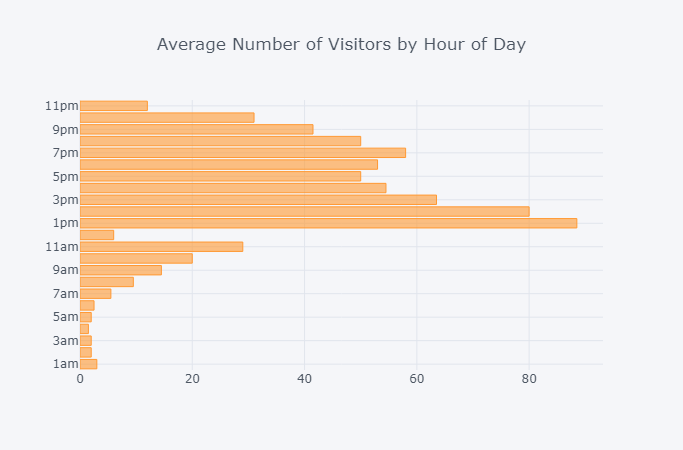

In [31]:
avg_times.median().iplot(kind='barh', title='Average Number of Visitors by Hour of Day')

From looking at this chart we can see that lunch hours are the busiest times for chipotle. This knowledge along with the fact that Chipotle's busiest days are during the workweek might support help support my theory about Chipotles customers having more income. To really test this hypothesis I will use the census data to look at the factors. This way I can analyze demographic factors of where customers come from. In order to do this I need to extract a frequency distributions of visitor cbgs.

In [32]:
chip_home_cbgs = {}
for cbg_count in sg_chip06['visitor_home_cbgs'].map(lambda x: eval(x)):
    for cbg, count in cbg_count.items():
        if cbg not in chip_home_cbgs:
            chip_home_cbgs[cbg] = count
        else:
            chip_home_cbgs[cbg] += count
                   
for cbg_count in sg_chip07['visitor_home_cbgs'].map(lambda x: eval(x)):
    for cbg, count in cbg_count.items():
        if cbg not in chip_home_cbgs:
            chip_home_cbgs[cbg] = count
        else:
            chip_home_cbgs[cbg] += round(((chip_home_cbgs[cbg] + count) / 2), 0)

In [33]:
chip_homes = pd.Series(chip_home_cbgs)
chip_homes.head()

060591103011    21.0
060591102021     7.0
060591101161     7.0
060591101102    13.0
060375545182    15.0
dtype: float64

In [34]:
chip_homes.describe()

count    34283.000000
mean        23.304466
std        319.598207
min          5.000000
25%          6.000000
50%         10.000000
75%         19.000000
max      38005.000000
dtype: float64

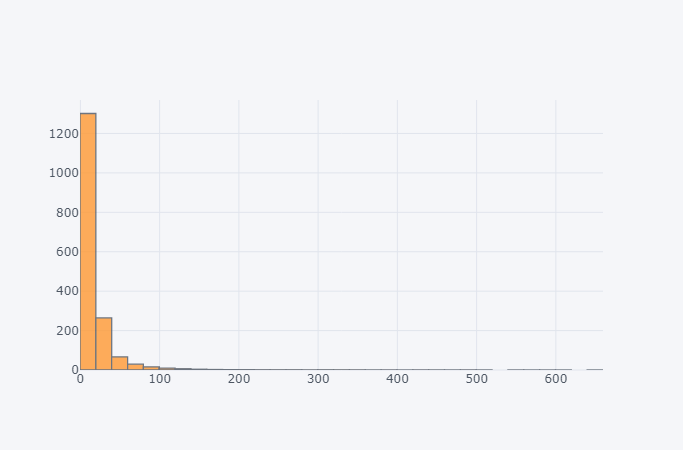

In [38]:
chip_homes[(np.abs(stats.zscore(chip_homes)) < 2)].iplot(kind='hist', histnorm='density', bins=50)

As we can see from the summary statistics of my frequency distribution there is clearly an uneven distribution of chipotle visitors per cbg. To get a better representation of the data I want to create a proportion of visitors compared to the overall population of their entire cbg. In order to do this I am going read the very large census csv file. This will take some optimization to make working with it more efficient.

In [41]:
census_data = pd.read_csv('community_survey_data.csv', converters={'census_block_group': lambda x: f"{x:12}"}, nrows=1000)

In [ ]:
census_data.head()

In [42]:
##Created dictionary to select only estimate columns and optimize dtypes of census data because it was so large and causing slowdowns
estimate_columns = {'census_block_group': 'object'}
for i in census_data.columns:
    if '(Estimate)' in i:
        if census_data.dtypes[i] == np.dtype('float64'):
            estimate_columns[i] = 'float32'
        elif census_data.dtypes[i] == np.dtype('int64'):
            estimate_columns[i] = 'int16'        

In [43]:
census_data = pd.read_csv('community_survey_data.csv', usecols=list(estimate_columns.keys()), dtype=estimate_columns, low_memory=False)

In [ ]:
census_data.tail()

In [ ]:
census_data.describe()

In [ ]:
census_data['SEX BY AGE: Total: Total population -- (Estimate)'] = census_data['SEX BY AGE: Total: Total population -- (Estimate)'].apply(lambda x: abs(x) if x < 0 else x)

In [ ]:
census_data['Chipotle Visitors'] = census_data['census_block_group'].apply(lambda x: chip_homes[x] if x in chip_homes.keys() else 0)

In [ ]:
chip_v = census_data[census_data['Chipotle Visitors'] > 0]

In [ ]:
chip_visitor_percent =  (chip_v['Chipotle Visitors']/ chip_v['SEX BY AGE: Total: Total population -- (Estimate)']) * 100

In [ ]:
chip_v.iplot(kind='scatter', mode='markers', x='SEX BY AGE: Total: Total population -- (Estimate)', y='Chipotle Visitors')

In [ ]:
chip_visitor_percent.sort_values(ascending=False).head(20)

In [ ]:
census_data.loc[census_data['census_block_group'] == '060379800131']

In [ ]:
data.loc[data['census_block_group'] == '060379800131']

In [ ]:
census_data.set_index('census_block_group')

In [ ]:
data.set_index('census_block_group')

In [ ]:
cc = data.merge(census_data, on='census_block_group')

In [ ]:
cc = cc.set_index('census_block_group')

In [ ]:
object_cols = ['visitor_home_cbgs', 'visitor_work_cbgs', 'related_same_day_brand', 'related_same_month_brand', 'top_brands', 'popularity_by_hour', 'popularity_by_day']
cc_numeric = cc.drop(columns=object_cols, axis=1).copy()

In [ ]:
from sklearn.model_selection import train_test_split
x = cc_numeric.drop('Chipotle Visitors', axis=1)
y = cc['Chipotle Visitors']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=0)

In [285]:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
%matplotlib inline
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

In [208]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #Used to see values without Scientific Notation for quick skimming
print((sg_chip06['distance_from_home']/1609.344).describe()) # convert meters to miles
(sg_chip07['distance_from_home'] / 1609.344).describe()

count   2319.000
mean       7.875
std       23.193
min        0.083
25%        3.569
50%        5.142
75%        7.528
max      659.833
Name: distance_from_home, dtype: float64


count   2345.000
mean       9.434
std       28.541
min        1.032
25%        3.739
50%        5.452
75%        7.974
max      624.676
Name: distance_from_home, dtype: float64